In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define paths
base_dir = '/content/drive/MyDrive/Colab Notebooks/npy/S2P'
korosi_dir = os.path.join(base_dir, 'Korosi')
tidak_korosi_dir = os.path.join(base_dir, 'TidakKorosi')

# Initialize lists for data and labels
data = []
labels = []

# Helper function to load and process each file
def load_file(file_path):
    # Assuming the data is in CSV format with a single column
    return np.load(file_path)

# Load data from 'Korosi' folder
for filename in os.listdir(korosi_dir):
    file_path = os.path.join(korosi_dir, filename)
    file_data = load_file(file_path)
    data.append(file_data)
    labels.append('Berkarat')

# Load data from 'Tidak Korosi' folder
for filename in os.listdir(tidak_korosi_dir):
    file_path = os.path.join(tidak_korosi_dir, filename)
    file_data = load_file(file_path)
    data.append(file_data)
    labels.append('Tidak Berkarat')


In [4]:
# Convert lists to numpy arrays
X = np.array(data)
y = np.array(labels)

# Encode the labels (0: TidakBerkarat, 1: Berkarat)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# First split: separate out test set (10% of total data)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Second split: separate validation set from remaining data (22.22% of remaining data, which is 20% of total)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2222, random_state=42)

# Reshape the input data to add the channel dimension
X_train = X_train.reshape(-1, 1024, 1)
X_val = X_val.reshape(-1, 1024, 1)
X_test = X_test.reshape(-1, 1024, 1)

# 3 Layers
model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(1024, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(Flatten())  # Add a flattening layer to convert 3D output to 1D
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1022, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1  (None, 511, 32)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 509, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 254, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 252, 128)          24704     
                                                                 
 flatten (Flatten)           (None, 32256)             0

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [6]:
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/5
11/11 [==============================] - 2s 97ms/step - loss: 0.6856 - accuracy: 0.6250 - val_loss: 0.6633 - val_accuracy: 0.5417
Epoch 2/5
11/11 [==============================] - 1s 71ms/step - loss: 0.6312 - accuracy: 0.7619 - val_loss: 0.5431 - val_accuracy: 1.0000
Epoch 3/5
11/11 [==============================] - 1s 72ms/step - loss: 0.4289 - accuracy: 1.0000 - val_loss: 0.2496 - val_accuracy: 1.0000
Epoch 4/5
11/11 [==============================] - 1s 74ms/step - loss: 0.1265 - accuracy: 1.0000 - val_loss: 0.0240 - val_accuracy: 1.0000
Epoch 5/5
11/11 [==============================] - 1s 74ms/step - loss: 0.0104 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000


In [7]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy*100:.2f}%')

2/2 [==============================] - 0s 27ms/step - loss: 0.0021 - accuracy: 1.0000
Accuracy: 100.00%


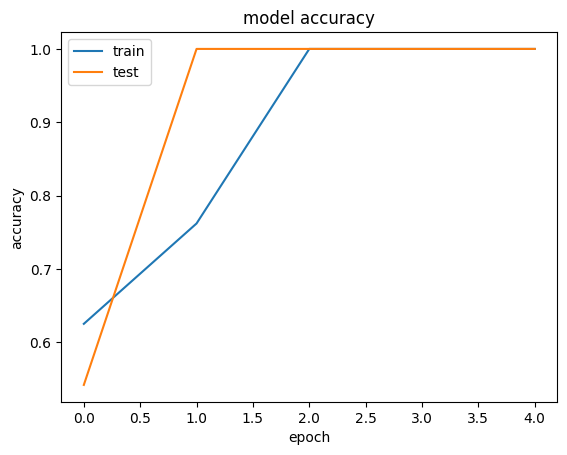

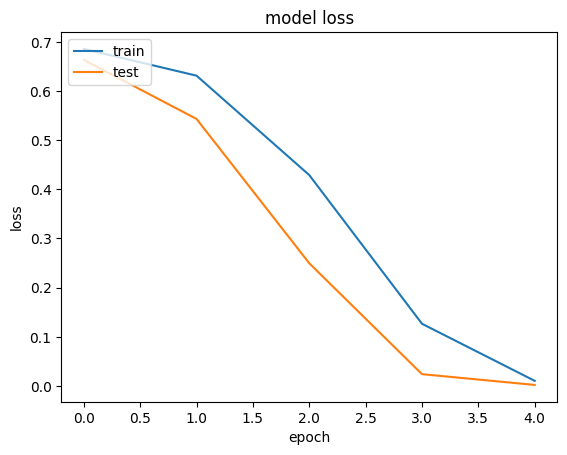

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
# Predict and calculate metrics
y_pred = (model.predict(X_test) > 0.5).astype("int32")

2/2 [==============================] - 0s 13ms/step


In [10]:
f1 = f1_score(y_test, y_pred)

print(f'F1 Score: {f1}')

F1 Score: 1.0


In [11]:
precision = precision_score(y_test, y_pred)

print(f'Precision: {precision}')

Precision: 1.0


In [12]:
recall = recall_score(y_test, y_pred)

print(f'Recall: {recall}')

Recall: 1.0


In [13]:
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Confusion Matrix:\n{conf_matrix}')

Confusion Matrix:
[[22  0]
 [ 0 26]]


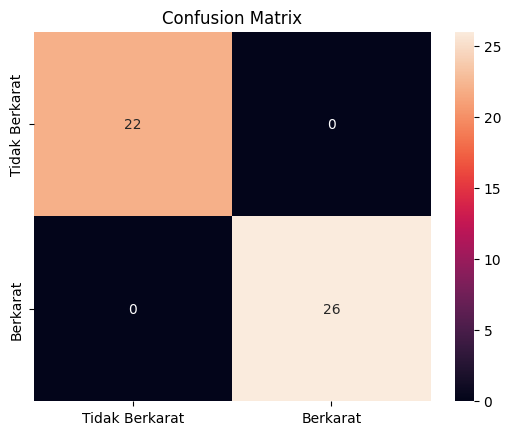

In [14]:
# prompt: plot the confusion matrix

import seaborn as sns
import matplotlib.pyplot as plt

# Get the class labels
class_labels = ['Tidak Berkarat', 'Berkarat']

# Create the confusion matrix visualization
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)

# Set the title and show the plot
plt.title('Confusion Matrix')
plt.show()
